In [224]:
import os
import sys
import json
import random
import subprocess
from pathlib import Path

from tqdm import tqdm
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sgfmill import sgf

sys.path.append(str(Path(os.getcwd()).parent))

from src import SGF_PATH, KATAGO_PATH, DATA_PATH
from src.utils.game import Game
from src.utils.sgf_helper import get_moves, opponent

In [164]:
root_path = Path(os.getcwd()).parent
with open(root_path.joinpath("data/analysis.json")) as f:
    data = json.load(f)


Text(0.5, 1.0, 'Score over time for black')

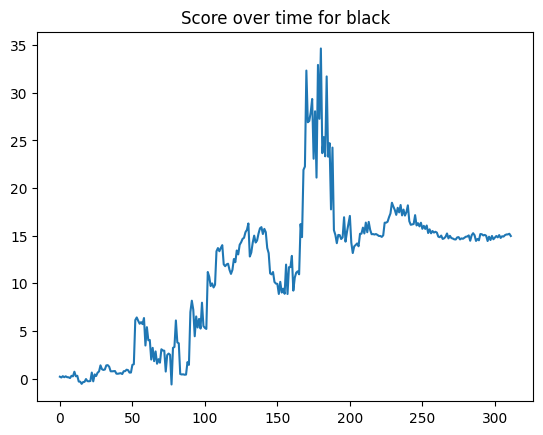

In [165]:
sgfname = "1.sgf"
game = data[sgfname]
game.sort(key=lambda m: m["turnNumber"])
plt.plot([m["rootInfo"]["scoreLead"] for m in game])
plt.title("Score over time for black")

In [177]:
def get_sgf_sequences(filenames) -> list:
    sgf_games = []
    for filename in filenames:
        with open(SGF_PATH.joinpath(f"selected_sgf/{filename}.sgf"), "rb") as f:
            sgf_games.append(f.read())
    return sgf_games


def has_captures(sgf_game, start, amount):
    last_captures = game.captured_black + game.captured_white

    for node in sgf_game[start : start + amount]:
        _, move = node.get_move()
        game.add_move(*move)
        new_amount_captures = game.captured_black + game.captured_white
        if new_amount_captures != last_captures:
            return True
    return False


def possible_variations(
    moves: list[tuple[str, str]], current_player: str, branch: list = []
) -> list:
    if not moves:
        return [branch]

    variations = []
    player_moves = [move for move in moves if move[0] == current_player]

    for pm in player_moves:
        new_moves = [m for m in moves if m != pm]
        new_branch = branch + [pm]
        variations += possible_variations(
            new_moves, opponent(current_player), new_branch
        )

    return variations


def send_position_into_analysis(process, data: dict) -> None:
    # katago analyse requires input as oneline
    data_string = json.dumps(data).replace("\n", "") + "\n"
    process.stdin.write(data_string)
    process.stdin.flush()

In [178]:
model_path = str(KATAGO_PATH.joinpath("models", "b28c512nbt.bin.gz"))
config_path = str(KATAGO_PATH.joinpath("configs", "analysis_example.cfg"))

process = subprocess.Popen(
    ["katago", "analysis", "-config", config_path, "-model", model_path],
    stdin=subprocess.PIPE,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True,
    bufsize=1,
)

In [179]:
sgf_games = get_sgf_sequences([i for i in range(1, 21)])

katago_sequence_results = []

game_id = 1
sgf_game = sgf.Sgf_game.from_bytes(sgf_games[game_id - 1]).get_main_sequence()[1:]

start, amount = 0, 0
while True:
    start, amount = random.randint(0, len(sgf_game) - 10), random.randint(3, 10)

    game = Game()
    for node in sgf_game[:start]:
        _, move = node.get_move()
        if not move:
            continue
        game.add_move(*move)

    if not has_captures(sgf_game, start, amount):
        break

moves = get_moves(SGF_PATH.joinpath(f"selected_sgf/{game_id}.sgf"))
selected_moves = moves[start : start + amount]
next_player = selected_moves[0][0]
varations = possible_variations(selected_moves, next_player)
possible_games = [moves[:start] + v for v in varations]

results = {str(i): [] for i in range(len(possible_games))}
analyse_turns = [i for i in range(start, start + amount)]

for i, g in enumerate(possible_games):
    data = {
        "id": str(i),  # has to be string
        "initialStones": [],
        "moves": g,
        "rules": "tromp-taylor",
        "komi": 6.5,
        "boardXSize": 19,
        "boardYSize": 19,
        "analyzeTurns": analyse_turns,
    }
    send_position_into_analysis(process, data)

for i in tqdm(range(amount * len(possible_games))):
    while True:
        new_data = process.stdout.readline().strip()
        if new_data:
            result = json.loads(new_data)
            results[result["id"]].append(result)
            break

diffs = [
    (
        k,
        abs(
            np.array([m["rootInfo"]["scoreLead"] for m in v])
            - np.array(
                [v[max(0, i - 1)]["rootInfo"]["scoreLead"] for i in range(len(v))]
            )
        ).mean(),
    )
    for k, v in results.items()
]
diffs.sort(key=lambda r: r[1])

katago_sequence_results.append(
    {"game_id": game_id, "start": start, "amount": amount, "diffs": diffs}
)
process.terminate()

100%|██████████| 16/16 [00:04<00:00,  3.74it/s]


In [180]:
process.terminate()

In [ ]:
with open("katago_results.json", "w") as f:
    json.dump(katago_sequence_results, f, indent=4)

<Figure size 1000x2000 with 0 Axes>

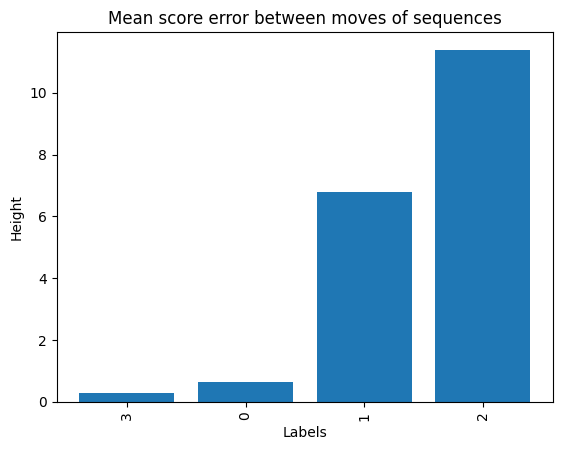

<Figure size 1000x2000 with 0 Axes>

In [181]:
plt.bar([d[0] for d in diffs], [d[1] for d in diffs])
plt.xlabel("Labels")
plt.ylabel("Height")
plt.title("Mean score error between moves of sequences")

plt.xticks(rotation=90)
plt.figure(figsize=(10, 20))


In [184]:
plt.plot(
    [
        m["rootInfo"]["scoreLead"]
        for m in katago_sequence_results[0][start : start + amount]
    ],
    label="Game Variation",
)
plt.plot([m["rootInfo"]["scoreLead"] for m in results[str(0)]], label="Other Bariation")
plt.title("Score lead of variations")
plt.legend()
plt.show()

KeyError: slice(230, 234, None)

In [203]:
with open(DATA_PATH.joinpath("katago_results.json")) as f:
    results = json.load(f)

In [188]:
results[0]

{'game_id': 1,
 'start': 102,
 'amount': 5,
 'diffs': [['2', 0.3194490420000001],
  ['0', 0.3928270380000004],
  ['3', 0.7044496480000003],
  ['6', 1.1063297840000001],
  ['4', 1.1347955400000007],
  ['1', 1.281914508],
  ['10', 1.293590004],
  ['8', 2.163529686],
  ['11', 2.392565252],
  ['5', 2.4845014900000004],
  ['9', 3.0943936059999997],
  ['7', 3.27277283]]}

In [204]:
runs_per_missing_moves = [
    (i, [result["amount"] for result in results].count(i)) for i in range(3, 9)
]
runs_per_missing_moves

[(3, 74), (4, 67), (5, 70), (6, 68), (7, 66), (8, 55)]

Text(0, 0.5, 'Count RUns')

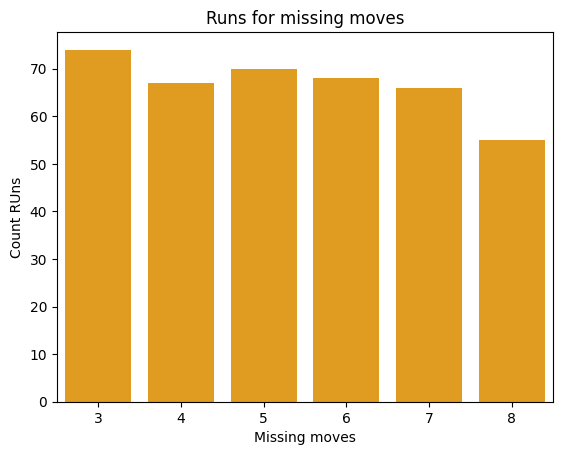

In [220]:
sns.barplot(
    x=[r[0] for r in runs_per_missing_moves],
    y=[r[1] for r in runs_per_missing_moves],
    errorbar=None,
    color="orange",
)
plt.title("Runs for missing moves")
plt.xlabel("Missing moves")
plt.ylabel("Count RUns")

In [262]:
for r in results:
    r["position"] = next(i for i, d in enumerate(r["diffs"]) if d[0] == str(0))
    r["position_percent"] = r["position"] / len(r["diffs"])
    r["score_diff_0"] = r["diffs"][0][1] - r["diffs"][r["position"]][1]

Text(0.5, 1.0, 'Position of correct variation')

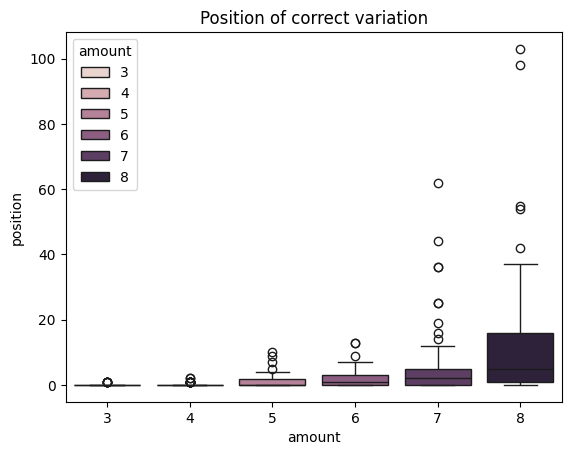

In [260]:
sns.boxplot(pd.DataFrame(results), x="amount", y="position", hue="amount")
plt.title("Position of correct variation")

Text(0.5, 1.0, 'Position in percent of correct variation')

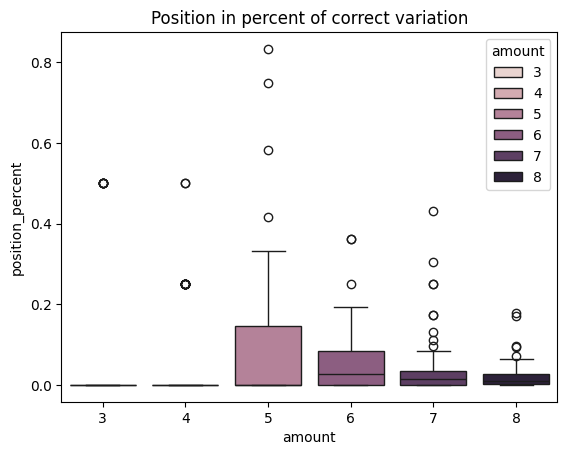

In [259]:
sns.boxplot(pd.DataFrame(results), x="amount", y="position_percent", hue="amount")
plt.title("Position in percent of correct variation")

In [ ]:
sns.boxplot(pd.DataFrame(results), x="amount", y="score_diff_0")